<table style="width: 100%; border-collapse: collapse;" border="0">
<tr>
<td><b>Created:</b> Tuesday 31 January 2017</td>
<td style="text-align: right;"><a href="https://www.github.com/rhyswhitley/fire_limitation">github.com/rhyswhitley/fire_limitation</td>
</tr>
</table>

<div>
<center>
<font face="Times">
<br>
<h1>Quantifying the uncertainity of a global fire limitation model using Bayesian inference</h1>
<h2>Part 2: Bayesian inference</h2>
<br>
<br>
<sup>1,* </sup>Douglas Kelley, 
<sup>2 </sup>Ioannis Bistinas,
<sup>3 </sup>Rhys Whitley,
<sup>4 </sup>Chantelle Burton, 
<sup>1 </sup>Tobias Marthews, 
<sup>6, 7 </sup>Ning Dong
<br>
<br>
<br>
<sup>1 </sup>Centre for Ecology and Hydrology, Maclean Building, Crowmarsh Gifford, Wallingford, Oxfordshire, United Kingdom
<br>
<sup>2 </sup>Vrije Universiteit Amsterdam, Faculty of Earth and Life Sciences, Amsterdam, Netherlands
<br>
<sup>3 </sup>Natural Perils Pricing, Commercial & Consumer Portfolio & Pricing, Suncorp Group, Sydney, Australia
<br>
<sup>4 </sup>Met Office United Kingdom, Exeter, United Kingdom
<br>
<sup>5 </sup>Centre for Past Climate Change and School of Archaeology, Geography and Environmental Sciences (SAGES), University of Reading, Reading, United Kingdom 
<br>
<sup>6 </sup>Department of Biological Sciences, Macquarie University, North Ryde, NSW 2109, Australia 
<br>
<br>
<h3>Summary</h3>
<hr>
<p> 
This notebook aims to quantify the model parameters of a global fire model (defined below). The model is driven by a number of covariates (X<sub>i=1, 2, ... M</sub>) that describe: cropland, pasture and urban area footprints; frequency of lightening ignitions, population density, vegetation cover and <i>Alpha</i>, a proxy measure of available soil moisture in the root zone. The model attempts to predict the impact of fire through burnt area and is thus the model target (Y).
</p>
<br>
<br>
<br>
<i>Python code and calculations below</i>
<br>
</font>
</center>
<hr>
</div>

### Model description
The model considers percentage of burnt area to be the joint product of a set of conditions that modulate fire through fuel load, ignitions, moisture and supression. Each control assumes some equilibrium point that desribes the optimal conditions for fire, that may be proportionally modified through some empirical relationship. These are briefly outlined below for the sake of comprehension in this notebook, but can be referred to in more detail in the model protocol located in the docs/ folder (<a href='file:///localhost/../docs/Model_description.pdf'>model protocol</a>).

\begin{eqnarray}
    F_{burn} &=& \prod_{i}S(x_{i}) \\[1em]
\end{eqnarray}

Where $S(x_{i})$ representes some measure of fire conditions by $i =$ fuel, moisture, ignitions and anthropagenic supression, and is describe by a sigmoid:

\begin{equation}
    S(x_{i=fuel, moist, ignite, suppr}) = \frac{1}{1 + \exp\{-b\cdot(x_i-a)\}}
\end{equation}

The $fuel$ sigmoid considers only fractional vegetation cover and therefore have no hyper-parameters. Sigmoids $moist$, $ignite$ and $suppr$ describe an aggregation of other climate and land-use covariates. Because these sigmoids are influenced by an aggregation of different drivers, they are influenced in turn by different sets of hyper-parameters; these are now described below.  

#### Fuel load covariate (no hyper-parameters)
\begin{equation}
    x_{fuel} = FPC^{p} \cdot (v_{fuel} \cdot (\alpha_{max}/\alpha -1) + 1)/(1+v_{fuel}) 
\end{equation}

#### Moisture covariate
\begin{equation}
    x_{moist} = \alpha + v_M \cdot EMC    
\end{equation}

where $EMC$ is the equilibrium moisture content.
#### Ignition covariate 
\begin{equation}
    x_{ignite} = Lightn + v_p\cdot A_{pasture} + v_{d1}\cdot\rho_{population}
\end{equation}

Where $Lightn$ is the number of cloud-to-ground lightning strikes, modified  as per Kelley et al. 2014.

#### Supression covariate 
\begin{equation}
    x_{supress} = A_{urban} + v_C\cdot A_{Crop} + v_{d2}\cdot\rho_{population} 
\end{equation}

This leaves 17 free parameters that need to be optimised against observations of burnt area.  

### Load libraries

In [2]:
%load_ext autoreload
%autoreload
import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import pymc3  as pm3 
from   pymc3.backends import SQLite
from   scipy  import optimize
from   theano import tensor as tt

import matplotlib.pyplot as plt

# setup nice plotting
plt.style.use('ggplot')
%matplotlib inline

# paths and parameters
                    # Full model
sample_pc     = 5 # = 10 # Percentage of grid cells samples (largest = 100%) - training set
nIterations   = 5000 # = 10000 # no. times it samples the posterior
nJobs         = 1   # = 2 # no. times it runs through optimisation proceedure = sample_pc * nJobs
#chains per job
nChains       = 1   # = 5

datPath       = "/users/global/megbro/UKESM/globfire_RH2.csv"
param_outpath = '../outputs/params_RH3.csv'
trace_db      = '../data/firemodel_trace.db'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2.1 Fire limitation model definition

Could possibly contain this in a class object, but I'm not sure theano can instantiate the object to be used by the GPU. If I've made absolutely no sense just then, then I would leave the following as is.

In [3]:
from pdb import set_trace as browser
def fuel_load(vegcover, alphaMax, fuel_pw, fuel_pg):
    """
    Definition to describe fuel load: while return the input; capability to be modified later.
    """
  
    return (vegcover**fuel_pw) * (fuel_pg * (alphaMax-1) + 1) / (1 + fuel_pg)

def moisture(alpha, rh, alpha_pw, rh_pw, cM):
    """
    Definition to describe moisture
    """
    return (alpha**alpha_pw + cM*rh**rh_pw) / (1 + cM)


def ignition(lightning, pasture, population_density, cP, cD1):
    """
    Definition for the measure of ignition
    """
    ignite = lightning + cP*pasture + cD1*population_density
    
    return ignite

def supression(cropland, population_density, cD2):
    """
    Definition for the measure of fire supression
    """
    return cropland + cD2*population_density

def tt_sigmoid(x, k, x0):
    """
    Sigmoid function to describe limitation using tensor
    """
    return 1.0/(1.0 + tt.exp(-k*(x - x0)))

## 2.2 Import data

Load data and do any necessary transformation needed for the Bayesian modelling framework. Rows are defined as a fraction of total data points (above). For full optimiatizaion, we set at 10%, but for testing purposes I've limited the number of rows I'm importing to 2%.

In [4]:
def load_with_buffer(filename, line_select, **kwargs):
    s_buf = StringIO()
    line_select = np.sort(line_select)
    with open(filename) as file:
        count = -1
        lineN = -1
        for line in file:
            lineN += 1
            if lineN == 0 or lineN == line_select[count]:
                s_buf.write(line)
                count += 1
                if count == len(line_select): break
            
    s_buf.seek(0)
    df = pd.read_csv(s_buf,**kwargs)
    return df

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f): pass
    return i + 1

DATAPATH = os.path.expanduser(datPath)

nlines      = file_len(DATAPATH)
npoints     = round(sample_pc * nlines / 100)
line_select = np.random.choice(range(0, nlines), npoints, False)
fd          = load_with_buffer(DATAPATH, line_select)

In [5]:
print(fd.keys())

Index(['alpha_', 'population_density', 'pasture', 'lightning_ignitions',
       'relative_humidity', 'alpha', 'fire', 'treecover', 'cropland',
       'vegcover'],
      dtype='object')


In [6]:
fd['alphaMax'] = fd['alpha_'] - 1.0 # alpha = alpha_12_months max

### Variable ranges

List of the expected ranges of variables. &#42; indicates a rough estimates, despite the parameter having a theoretical range of  infinity (&infin;). <sup>+</sup> indicates that the limitation is not hard, and values can go beyond the maximum range.
<br>
<br>
emc: [0, 2]
<br>
cropland: [0, 1]
<br>
pasture: [0, 1]
<br>
lightning_ignitions: [0, 10&#42;]
<br>
alpha: [0, 1.5]
<br>
population_density: [0, 40,000&#42;]
<br>
treecover: [0, 1]
<br>
alpha_:  [1, 5&#42;]
<br>
fire:  [0, 1<sup>+</sup>]
<br>
vegcover: [0, 1]
<br>
alphaMax: [0, 4&#42;]
<br>
relative_humidity: [0, 1<sup>+</sup>]

Do a sanity check to make sure our data has imported correctly

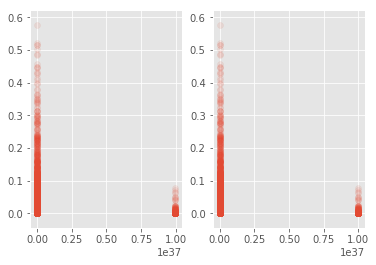

In [7]:
plt.subplot(1, 2, 1) # 1 = nrows, 2 = ncols, n = location of next plot (can write as 121)
plt.scatter(fd['alpha'], fd['fire'], alpha = 0.1)
plt.subplot(122)
plt.scatter(fd['alphaMax'], fd['fire'], alpha = 0.1)

Checking all parameters

alpha_


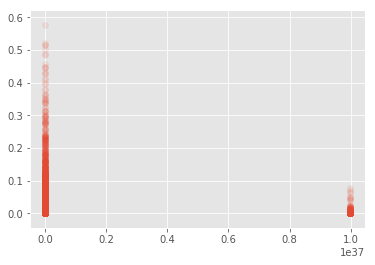

population_density


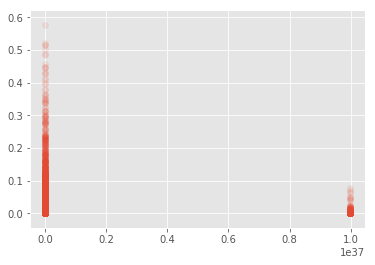

pasture


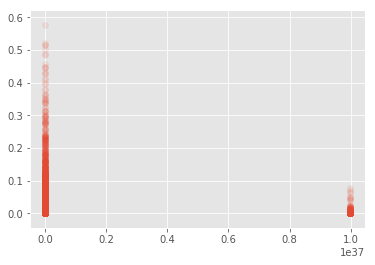

lightning_ignitions


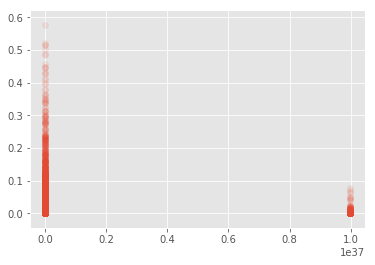

relative_humidity


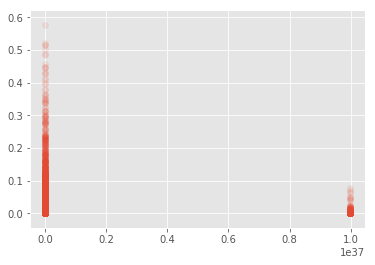

alpha


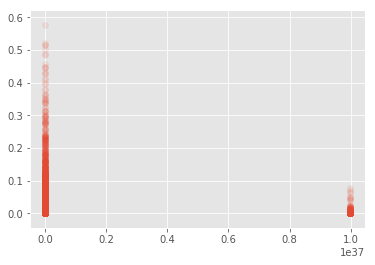

fire


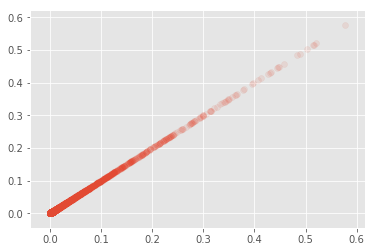

treecover


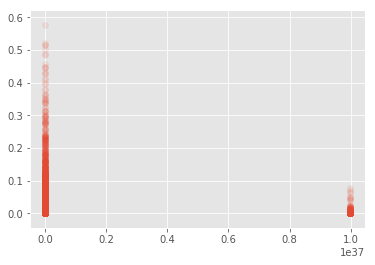

cropland


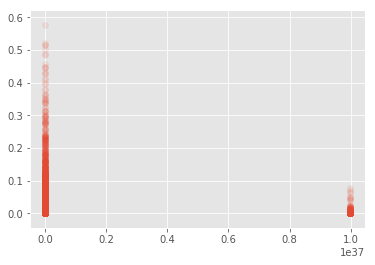

vegcover


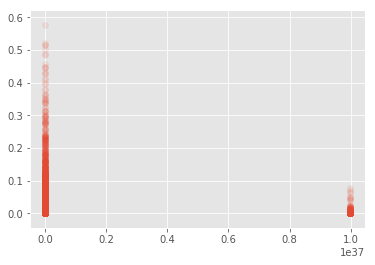

alphaMax


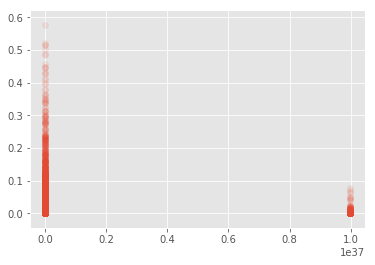

In [8]:
i = 1
for key in fd.keys():
    print(key)
    plt.scatter(fd[key], fd['fire'], alpha = 0.1)
    plt.show()
    i = i + 1

Some extreme numbers are included in the variables, so using the limitations above the dataframe is corrected.

55195
Dataframe length in alpha: 55195
Dataframe length in population_density: 55195
Dataframe length in pasture: 55195
Dataframe length in treecover: 55195
Dataframe length in cropland: 55195
Dataframe length in lightning_ignitions: 55195
Dataframe length in alpha_: 55195
Dataframe length in fire: 55195
Dataframe length in vegcover: 55195
Dataframe length in alphaMax: 55195
Dataframe length in relative_humidity: 55195
55195
55195
55195
55195
55195
55195
55195
55195
55195
55195
55195
alpha_


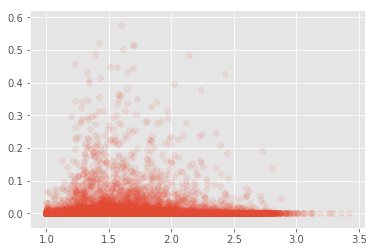

population_density


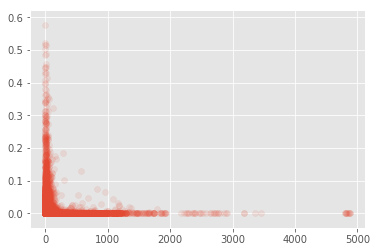

pasture


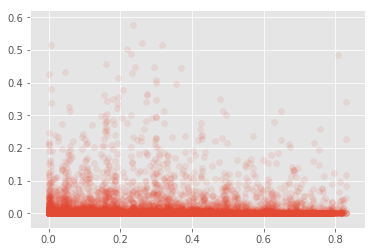

lightning_ignitions


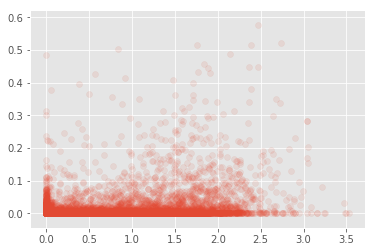

relative_humidity


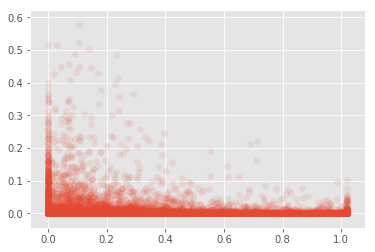

alpha


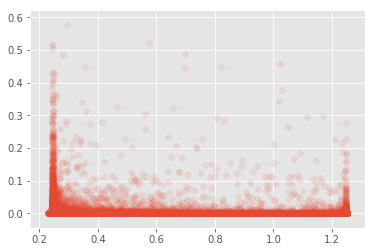

fire


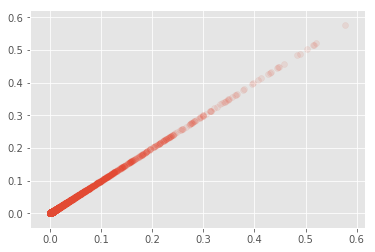

treecover


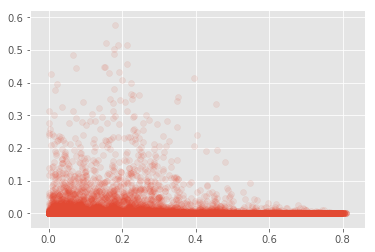

cropland


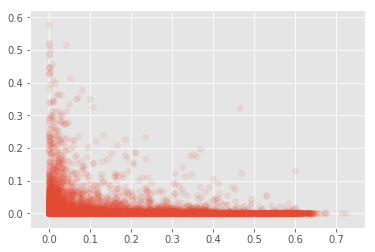

vegcover


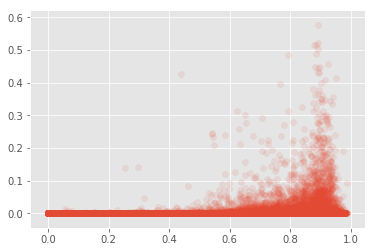

alphaMax


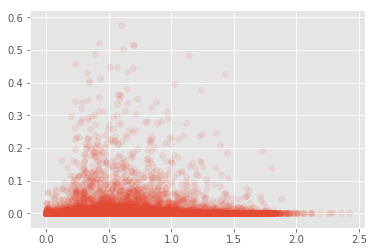

In [16]:
# Checking variable limitations in data
limits = {'alpha'              :    1.5,
          'population_density' :    40000,
          'pasture'            :    1,
          'treecover'          :    1,
          'cropland'           :    1,
 #         'emc'                :    2,
          'lightning_ignitions':    10,
          'alpha_'             :    5,
          'fire'               :    2,
          'vegcover'           :    1,
          'alphaMax'           :    4,
          'relative_humidity'  :    1.5
          }
print(len(fd))


# Adding in limitations and viewing dataframe length. 
for key, val in limits.items():
    lim = len(fd[fd[key]<=val])
    print('Dataframe length in %s: %d' %(key,lim))
    fd = fd[fd[key]<=val]

for key, val in limits.items():
    fd = fd[fd[key]<=val]
    print(len(fd))
    
i = 1
for key in fd.keys():
    print(key)
    plt.scatter(fd[key], fd['fire'], alpha = 0.1)
    plt.show()
    i = i + 1
    
fd['alpha'] /= fd["alpha"].max()

In [17]:
print(fd.info())
print(fd.max())
fd.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55195 entries, 451 to 232181
Data columns (total 11 columns):
alpha_                 55195 non-null float64
population_density     55195 non-null float64
pasture                55195 non-null float64
lightning_ignitions    55195 non-null float64
relative_humidity      55195 non-null float64
alpha                  55195 non-null float64
fire                   55195 non-null float64
treecover              55195 non-null float64
cropland               55195 non-null float64
vegcover               55195 non-null float64
alphaMax               55195 non-null float64
dtypes: float64(11)
memory usage: 7.6 MB
None
alpha_                    3.416324
population_density     4874.432600
pasture                   0.830505
lightning_ignitions       3.527873
relative_humidity         1.020000
alpha                     1.000000
fire                      0.577168
treecover                 0.810234
cropland                  0.723839
vegcover             

,alpha_,population_density,pasture,lightning_ignitions,relative_humidity,alpha,fire,treecover,cropland,vegcover,alphaMax
451,1.081346,1.478404,0.042837,0.223393,1.020000,0.992742,0.000000,0.662500,2.481093e-02,0.980938,0.081346
458,1.225263,20.015718,0.182841,0.341574,1.020000,0.813701,0.000034,0.365000,3.920123e-02,0.937187,0.225263
465,2.161986,1.031793,0.428668,1.250658,0.673722,0.311745,0.000045,0.019375,3.615075e-04,0.573750,1.161986
493,1.461964,0.001706,0.000000,0.641698,0.494980,0.200527,0.000000,0.036250,0.000000e+00,0.726562,0.461964
494,1.365622,0.002523,0.000000,0.368794,0.547604,0.210464,0.000000,0.004687,0.000000e+00,0.646250,0.365622
506,1.711954,1.109738,0.257637,1.251383,0.635338,0.269109,0.006090,0.086250,1.336552e-01,0.869062,0.711954
511,1.636620,0.000638,0.000000,0.648140,0.329487,0.194873,0.000000,0.002500,0.000000e+00,0.583750,0.636620
515,1.641762,0.215742,0.275655,0.833540,0.316234,0.192354,0.000000,0.010937,1.661749e-04,0.322813,0.641762
517,1.811769,0.559883,0.555863,1.279780,0.267220,0.193240,0.000008,0.000000,6.845390e-07,0.562187,0.811769
518,1.974998,53.724716,0.329628,1.916412,0.019920,0.192776,0.005054,0.033750,3.189427e-01,0.787813,0.974998


## 2.3 Baysian framework

A simple explanation of Baye's law is:

\begin{equation}
    P(\beta|X) \propto P(\beta)\cdot P(X|\beta)
\end{equation}

where $X$ is our data (observations of some arbitrary system), and $\beta$ our set of unexplained parameters that describe the reponse of our _proposed understanding_ of this system as it varies with $X$.

### 2.3.1 Prior definitions
Because I have no idea what the uncertainty on the hyper parameters should look like (beyond $\beta> 0$), I've set them all as uniform, where bounds are either physical limits of the variable in question, or set generously beyond what is realistic plausable. Some of them can possibly be described as exponential or half-normal, due to the physical nature of $\beta$, but we can play around with that later.

\begin{eqnarray}
    P(\beta) &=& \prod_{i=1}^{4}P(a_i)\prod_{i=1}^{4}P(b_i)\cdot P(\sigma)\cdot P(v_c)P(v_p)P(v_{d,1})P(v_{d,2}) \\[1.5em]
    P(a) = P(b) = P(\sigma) &=& \mathcal{N}(0, 1) \\[1em]
    P(v_c) = P(v_p) = P(v_{d,1}) = P(v_{d,2}) &=& \mathcal{U}(\beta_{\min}, \beta_{\max}) \\[1.5em]
\end{eqnarray}

I'm not totally sure about the maths above being right, but it's just to show that _full_ prior is normal. Important, because we'll also describe the error (likelihood) as normal, such that the posterior is therefore normal (conjugate); i.e. $\mathcal{N}\times\mathcal{N}=\mathcal{N}$ (expansion happens in the mean of the exponent). 

Back to the code.., `pymc3` is quite funky in that it allows me to create an empty `Model()` object and just add things to it as I need them using a `with` statement. I've called our Bayesian model `fire_error` as that is what we are trying to Quantify.



In [21]:
with pm3.Model() as fire_error:
    
# first for the sigmoids  
    fuel_x0        = pm3.Uniform('fuel_x0'       ,    -1.0,  2.0)
    fuel_k         = pm3.Uniform('fuel_k'        ,     0.0, 1000.0)
    fuel_pw        = pm3.Uniform('fuel_pw'       ,     1.0, 20.0)
    fuel_pg        = pm3.Uniform('fuel_pg'       ,     0.0, 1.0)
    
    moisture_x0    = pm3.Uniform('moisture_x0'   ,    -1.0,  2.0)
    moisture_k     = pm3.Uniform('moisture_k'    ,     0.0, 1000.0)
    alpha_pw       = pm3.Exponential('alpha_pw'  ,     1.0)
    rh_pw          = pm3.Exponential('rh_pw'     ,     1.0)
    
    ignition_x0    = pm3.Uniform('ignitions_x0'   ,    -4.0, 4.0)
    ignition_k     = pm3.Uniform('ignitions_k'    ,     0.0, 1000.0)
    
    suppression_x0 = pm3.Uniform('suppression_x0',     -1.0,  2.0)
    suppression_k  = pm3.Uniform('suppression_k' ,     0.0, 10.0)
    
    max_f          = pm3.Uniform('max_f'         ,     0.0,    1.0)
    #pow_f          = pm3.Uniform('pow_f'         ,     0.0,    1.0)
# now for the hyper-parameters that describe the independent fire condition covariates
    cM  = pm3.Uniform('cM' , 0.0, 1e4)
    #cMT = pm3.Uniform('cMT', 0.0, 1e4)
    #cL  = pm3.Uniform('cL' , 0, 1e4)
    cP  = pm3.Uniform('cP' , 0.0, 1e4)
    cD1 = pm3.Uniform('cD1', 0.0, 1e4)
    cD2 = pm3.Uniform('cD2', 0.0, 1e4)
    #cDmax = pm3.Uniform('cDmax', 0, 1e4)
# describe the standard deviation in the error term
    sigma = pm3.HalfNormal('sigma', sd=1)

### 2.3.2 Likelihood definition

For the sake of simplicity (and because I don't really know any better), we define the model error as normally distributed (i.i.d.) although it most likely isn't. We could make this more complicated later by defining the error as heteroscedastic, but I wouldn't bother with that until we have some idea of the convergence. We're describing the error (observations minus model predictions) as follows:

\begin{eqnarray}
    P(X|\beta) &=& \mathcal{N}(F_{burn}, \sigma) \\[1em]
    \mathcal{N}(F_{burn}, \sigma) &=& \frac{N}{\sigma\sqrt{2\pi}}\exp\left\{\sum_{i=1}^{N}\left(\frac{y_i - F_{burn, i}}{\sigma_i}\right)^2\right\}
\end{eqnarray}

where $y_i$ is a set of observations we're attempting to optimise on. Below is the code that describes the above:

(I've changed emc to relative_humidity) 21/7/19

In [22]:
with fire_error:
    
    # transform hyper-covariates 
    f_fuel        = fuel_load(fd["vegcover"].values, fd["alphaMax"].values, fuel_pw, fuel_pg)
    
    f_moisture    = moisture(fd["alpha"].values, fd["relative_humidity"].values, 
                             alpha_pw, rh_pw, cM)
    
    f_ignition    = ignition(fd["lightning_ignitions"].values, \
                             fd["pasture"].values, \
                             fd["population_density"].values, \
                             cP, cD1)
    
    f_suppression = supression(fd["cropland"].values, \
                               fd["population_density"].values, \
                               cD2)
    
    # burnt area is assumed to be the product of the 4 sigmoids
    
    prediction = max_f * np.product([tt_sigmoid(f_fuel, fuel_k, fuel_x0),
                             tt_sigmoid(f_moisture, - moisture_k, moisture_x0),
                             tt_sigmoid(f_ignition, ignition_k, ignition_x0),
                             tt_sigmoid(f_suppression, - suppression_k, suppression_x0)])
                  
    # calculate the error between observed and predicted burnt area
    error = pm3.Normal('error', mu=prediction, sd=sigma, observed=fd['fire'].values)

### 2.3.3 Posterior sampling

Because it is nigh impossible to determine the posterior solution analytically we will instead sample the information space to **infer** the posterior solutions for each of the model parameters. In this case we are using a Metropolis-Hasting step MCMC.

I've tried using No-U-Turn (NUTS) sampling (which is the new kid on the block), but there are issues with it's current implementation in pymc3 (see github repo issues). Can use it once problems are ironed out - but TBH it doesn't matter if we're getting a reasonable convergence.

In [23]:
nChains = nChains* nJobs
with fire_error:
    
    # help the sampling out by quickly finding an optimal start position
    start = pm3.find_MAP(model=fire_error.model, fmin=optimize.fmin_powell)
    
    # set the step-method (criteria algorithm for moving around information space)
    step = pm3.Metropolis()
    
    # save our sampling to disk so we can access it later
    #db_save = SQLite(trace_db)
    
    # do the sampling
    mcmc_traces = pm3.sample(nIterations * nJobs, step=step, start=start, njobs= nJobs, chains = nChains) 

/users/global/doukel/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = 1.4419e+05:  14%|█▍        | 700/5000 [00:10<00:55, 76.85it/s]

Optimization terminated successfully.
         Current function value: -144189.279467
         Iterations: 3
         Function evaluations: 704


logp = 1.4419e+05:  14%|█▍        | 704/5000 [00:30<00:55, 76.85it/s]Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sigma_log__]
>Metropolis: [cD2_interval__]
>Metropolis: [cD1_interval__]
>Metropolis: [cP_interval__]
>Metropolis: [cM_interval__]
>Metropolis: [max_f_interval__]
>Metropolis: [suppression_k_interval__]
>Metropolis: [suppression_x0_interval__]
>Metropolis: [ignitions_k_interval__]
>Metropolis: [ignitions_x0_interval__]
>Metropolis: [rh_pw_log__]
>Metropolis: [alpha_pw_log__]
>Metropolis: [moisture_k_interval__]
>Metropolis: [moisture_x0_interval__]
>Metropolis: [fuel_pg_interval__]
>Metropolis: [fuel_pw_interval__]
>Metropolis: [fuel_k_interval__]
>Metropolis: [fuel_x0_interval__]

  0%|          | 2/5500 [00:02<2:00:23,  1.31s/it]Exception in thread Thread-4:
Traceback (most recent call last):
  File "/users/global/doukel/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/users/global/doukel/anaconda3/lib/pyth

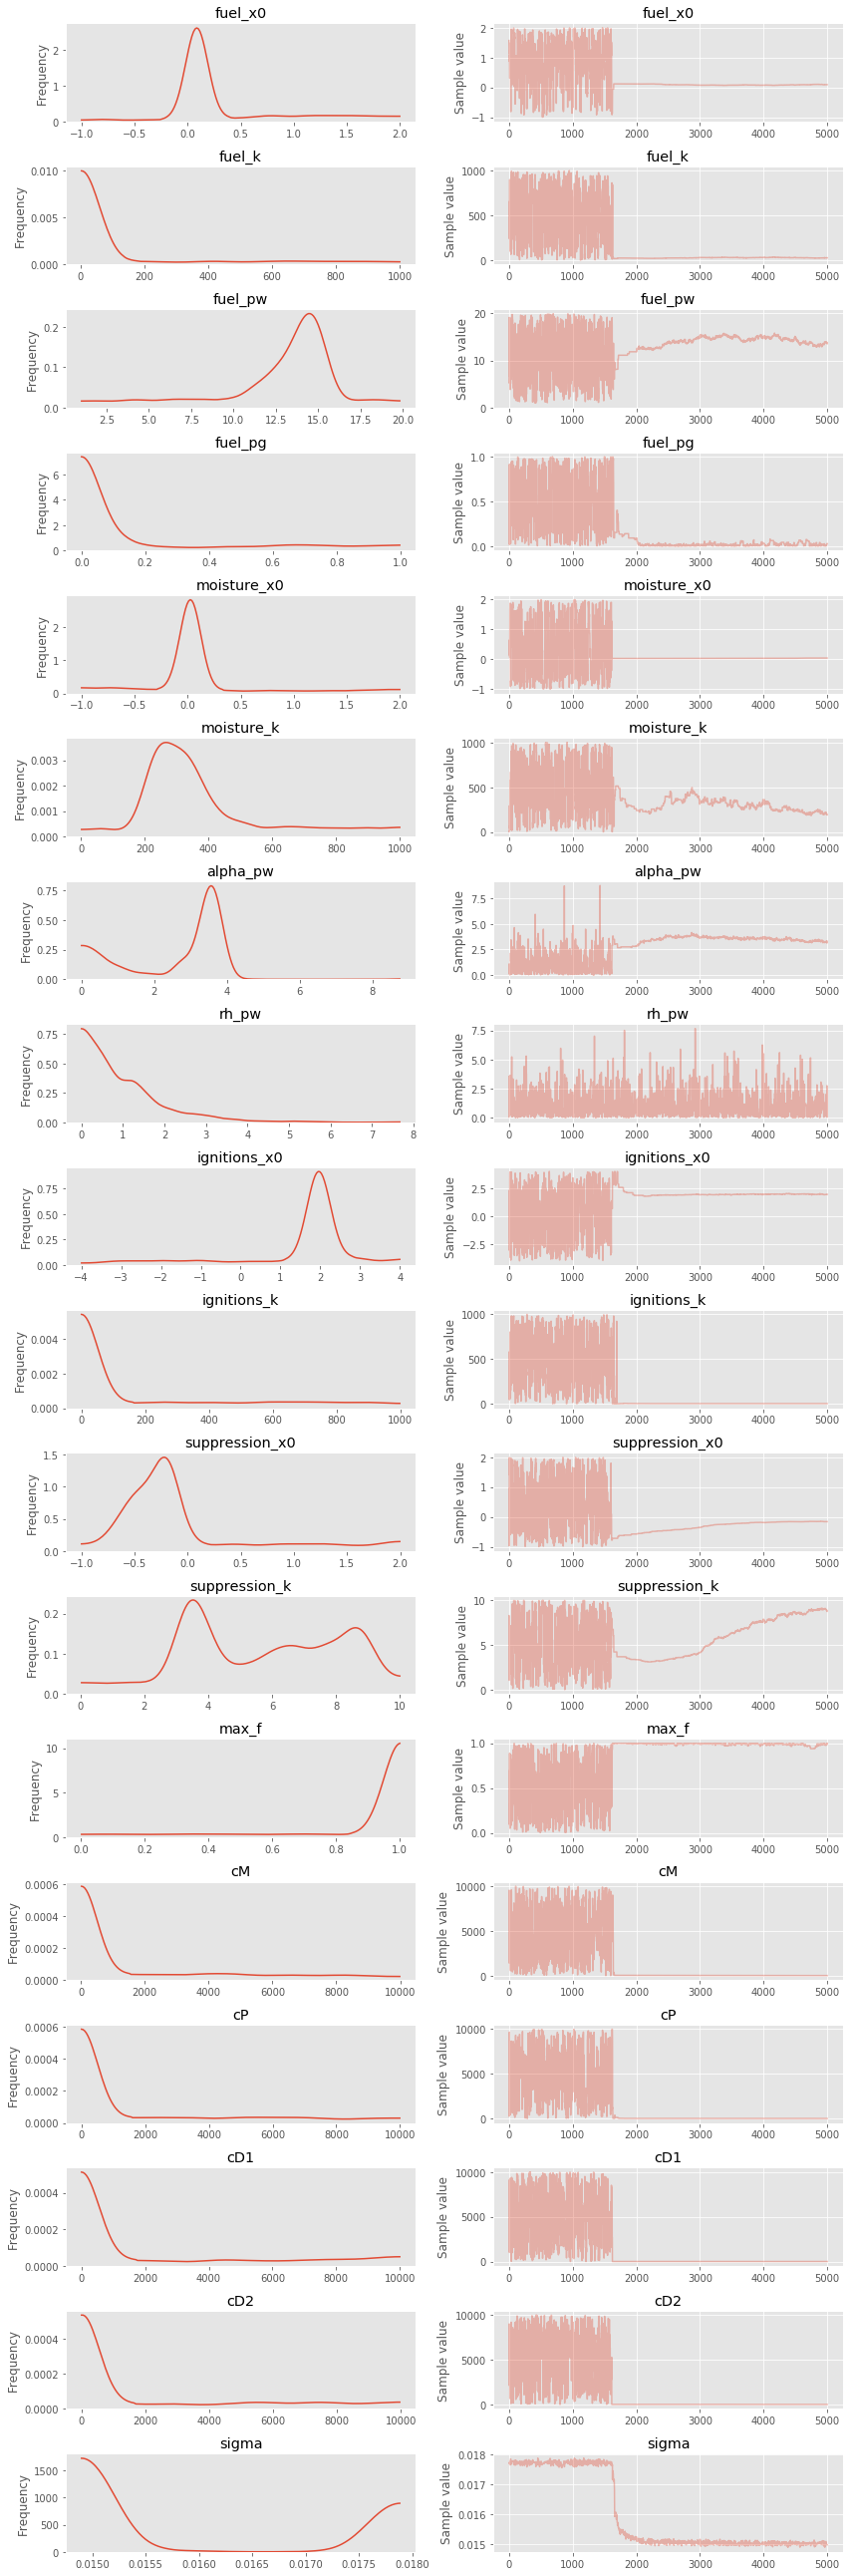

In [24]:
pm3.traceplot(mcmc_traces);

## Output paramaters
The iterations at the start are just letting the optimization settle. So we will only sample to last 50% of iterations for futher analysis. We also export these to csv, which others can use to do their own analysis.

In [25]:
varnames = mcmc_traces.varnames


def cutLastX(varname, mcmc_traces, ncut = 50):
    vals = mcmc_traces.get_values(varname)
    def subcut(vals, r, ncut = 50):
        cut_np = (r+1) * round(len(vals)/nChains)
        ncut = round(len(vals) * ncut / (nChains *100))
        return vals[(cut_np - ncut):cut_np]
    vals = [subcut(vals, r) for r in range(nChains)]
    return np.array(vals).flatten()

vals = [cutLastX(i, mcmc_traces) for i in varnames]
vals = pd.DataFrame(np.array(vals).T, columns=varnames)

vals.to_csv(param_outpath, index=False)

## Plotting

Let look at the pdf of the last 50% of iterations for each parameter

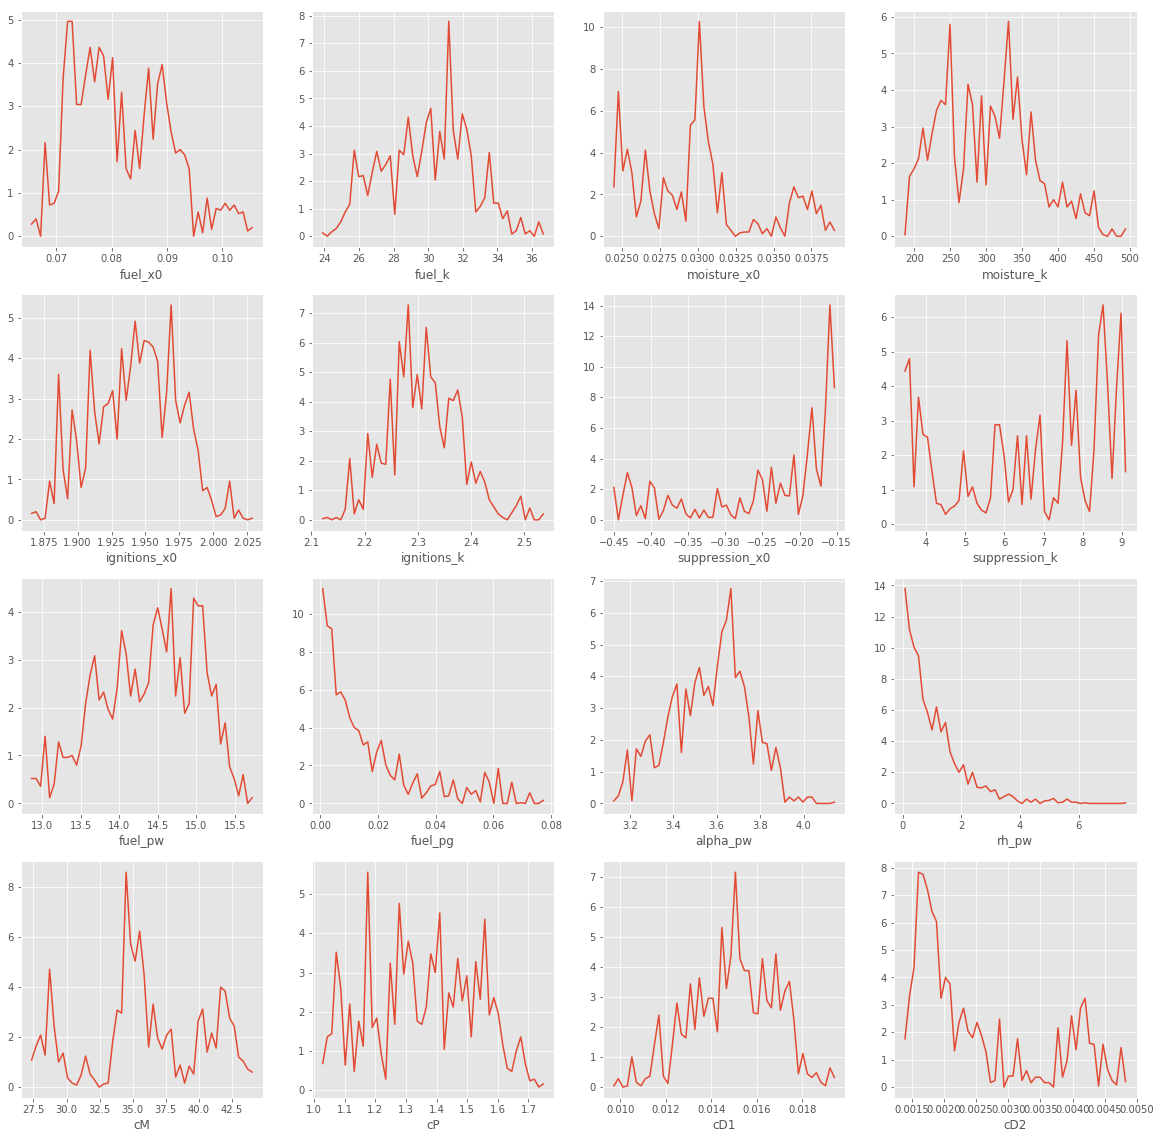

In [27]:
variables2Plot = ['fuel_x0'       , 'fuel_k',
                  'moisture_x0'   , 'moisture_k',
                  'ignitions_x0'  , 'ignitions_k',
                  'suppression_x0', 'suppression_k',
                  'fuel_pw'       , 'fuel_pg',
                  'alpha_pw'      , 'rh_pw',
                  'cM',
                  'cP',
                  'cD1'           , 'cD2']

nvar = len(variables2Plot)
npcol = 4
nprow = np.ceil(nvar / npcol)

plt.figure(figsize=(20,5 * nprow))
def plotVar(var1, pn):
    plt.subplot(npcol, nprow, pn)
    param = vals[var1]
    
    hist, bins = np.histogram(param, bins=50)
    hist = 100.0 * hist / np.sum(hist)
    bins = bins[1:] - np.diff(bins)/2
    plt.plot(bins, hist)
    plt.xlabel(var1)
    
pn = 0
for i in variables2Plot:
    pn = pn + 1
    plotVar(i, pn)

And what to the sigmoids look like?

In [22]:
from pdb import set_trace as browser

def pltVsFire(x, xlab, pnt = 'o', *args, **kw):
    plt.plot(x, fd.fire, pnt, alpha = 0.03, *args, **kw)
    plt.xlabel(xlab)
    
def np_sigmoid(x, k, x0):
    """
    Sigmoid function to describe limitation using tensor
    """
    return 1.0/(1.0 + np.exp(-k*(x - x0)))

def returnSigmoid(x, k, x0):
    return np_sigmoid(x, k, x0)
    
def meanParam(x, x0, k, kmult = 1.0):
    x0 = np.mean(vals[x0])
    k  = np.mean(vals[k]) * kmult

    return returnSigmoid(x, k, x0)

def randomParam(x, x0, k, kmult = 1.0, size = 100):
    ps = np.random.choice(vals.shape[0], size = size, replace = False)
    return [returnSigmoid(x, vals[k][i] * kmult, vals[x0][i]) for i in ps]

0.9522944784923952


(0, 1)

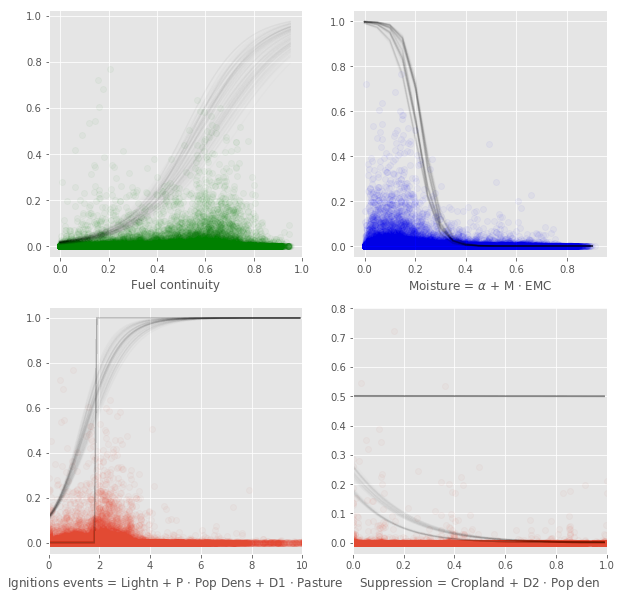

In [23]:
plt.figure(figsize=(10, 10))

####################
## Fuel           ##
####################
plt.subplot(2, 2, 1)
## scatter plot
fp = np.mean(vals['fuel_pw'])
fg = np.mean(vals['fuel_pg'])

f_fuel = fuel_load(fd["vegcover"].values, fd["alphaMax"].values, fp, fg)
print(f_fuel.max())
pltVsFire(f_fuel, "Fuel continuity", 'go')

## Line of best fit
Fuel = np.arange(0, f_fuel.max(), 0.01)
r_fuel = randomParam(Fuel, 'fuel_x0', 'fuel_k')
for r in r_fuel: plt.plot(Fuel, r, 'k', alpha=.01)

####################
## Moisture       ##
####################
plt.subplot(2, 2, 2)
## scatter plot
cM = np.mean(vals['cM'])
cMT = np.mean(vals['cMT'])
f_moisture = moisture(fd["alpha"].values, fd["relative_humidity"].values, fd["treecover"].values, cM, cMT)
pltVsFire(f_moisture , "Moisture = $\\alpha$ + M $\cdot$ EMC",'bo')

## Line of best fit
mst = np.arange(0.0, f_moisture.max(), 0.05)
r_moisture = randomParam(mst, 'moisture_x0', 'moisture_k', -1)
for r in r_moisture: plt.plot(mst, r, 'k', alpha=.01)


####################
## Ignitions       ##
####################
plt.subplot(2, 2, 3)
## scatter plot 
cP  = np.mean(vals['cP' ])
cD1 = np.mean(vals['cD1'])
igniteMax = 10

f_ignite = ignition(fd["lightning_ignitions"].values, \
                    fd["pasture"].values, \
                    fd["population_density"].values, \
                    cP, cD1)

pltVsFire(f_ignite, "Ignitions events = Lightn + P $\cdot$ Pop Dens + D1 $\cdot$ Pasture")

## Line of best fit
Ignite = np.arange(0.0, igniteMax, 0.1)
r_Ignite = randomParam(Ignite, 'ignitions_x0', 'ignitions_k')
for r in r_Ignite: plt.plot(Ignite, r, 'k', alpha=.01)

plt.xlim(0, igniteMax)

####################
## Suppression    ##
####################
plt.subplot(2, 2, 4)
#scatter plot
cD2 = np.mean(vals['cD2'])
f_suppression = supression(fd["cropland"].values, \
                           fd["population_density"].values, \
                           cD2)

pltVsFire(f_suppression, "Suppression = Cropland + D2 $\cdot$ Pop den")

# Line of best fit
Suppress = np.arange(0, 1, 0.01)
r_suppression = randomParam(Suppress, 'suppression_x0', 'suppression_k', -1.0)
for r in r_suppression: plt.plot(Suppress, r, 'k', alpha=.01)

plt.xlim(0, 1)